In [1]:
"""
Created By    : Jared W. Marquis
Creation Date : 01 August 2022
Course        : ATSC 528 - Atmospheric Data Analysis
Assignment    : #03 - Statistical Objective Analysis

Purpose:
Script to take sparse upper air observations and analyze them on a
polar stereographic map projection using statistical objective analysis.

A Barnes weighting analysis is used to create a background field at analysis locations, 
Script to torment the ATSC 528 students specifically.

"""
__author__    = "Ev Bohlmann"
__contact__   = "ev.bohlmann@und.edu"

In [2]:
### Import Required Modules (shouldn't need to change) ###
import numpy as np                 #numpy for math
import matplotlib.pyplot as plt    #matplotlib for plotting
import cartopy.crs as ccrs         #cartopy for plotting on map
import cartopy.feature as cfeature #cartopy basic shapefiles
import math ## added for the exp() function

In [3]:
## THE FUNCTION CELL!!

## weighting function (from assignment)
def wik(dik,kd,roi):
    if dik > roi:
        thisweight = 0
    else:
        thisweight = np.exp((-dik**2)/kd)
    return thisweight

## bilinear interp formula for analysis values at ob locations (from successive corrections)
## edited per jared's commentary on prev assignment
def bilinear(obsx,obsy,xg,yg,prev,prevrad):
    ## base value lat lons
    baselat = -0.063
    baselon = .189
    delta = 0.0127
    ## 1st, convert x and y indices of ob locations
    idx_x = (obsx - baselon)/delta ## redefines the origin and resizes the grid
    idx_y = (obsy - baselat)/delta ##  ^^^^^
    
    ## call an empty array for the bilinear interp values
    bi_val = np.zeros(shape=len(idx_x))

    ## remove indices that do not fit within the 0-22 and 0-28 criteria
    for m in range(len(idx_x)):
        if idx_x[m] > 21 or idx_x[m] < 0 or idx_y[m] > 27 or idx_y[m] < 0: ## 21 and 27 are the ceilings due to indexing being indexing
            idx_x[m] = np.nan
            idx_y[m] = np.nan ## this and above line mean that any ob with a recreated index value outside of the analysis grid is a nan value
            
            ## perform analysis to interpolate points outside of the grid space and shovel directly into the bilinear interp 
            ## i fear that shoving this into another function would screw me up, so I am not going to do that
            xp = obsx[m]
            yp = obsy[m]
            theseweights = np.zeros(shape=(len(xg),len(xg[i])))
            for a in range(len(xg)):
                for s in range(len(xg[i])):
                    dx = xp - xg[a,s]
                    dy = yp - yg[a,s]
                    thisdist = ((dx**2 + dy**2)**0.5)
                    #theseweights[a,s] = wik(thisdist,kd)
                    theseweights[a,s] = wik(thisdist,kd,re) ## changed for new weight function; MAKE SURE KD & RE ARE HARD CODED LOL
                    ## theseweights array only filled for singular ob location, so proceed w/ caution
            flat_weights = theseweights.flatten()
            flat_anhghts = prev.flatten()
            bigk = len(flat_weights) - 1 ## number of analysis points, adjusted for index
            k = 0
            num = 0 ## as in cressman function
            denom = 0
            while k <= bigk:
                if flat_weights[k] == 0:
                    bi_val[m] = np.nan ## weight of zero means outside ROI, sets value to nan in interpolated array
                    #print('zero weight, restarting loop')
                    k += 1
                    continue
                else:
                    num += (flat_weights[k]) * (flat_anhghts[k])
                    denom += flat_weights[k]
                    k += 1
            if denom == 0:
                bi_val[m] = np.nan ## a secondary check, to avoid the nefarious divide by zero error
            else:
                an_val = num / denom
                bi_val[m] = an_val
        ## above process should retain the nan value in the idx_x and idx_y arrays so the bilinear part of this function doesn't break
        else:
            continue
    ## next up, take each grid point and find the lower left nearest grid point index
    bl_x = np.zeros(shape=len(idx_x))
    bl_y = np.zeros(shape=len(idx_y))
    for n in range(len(idx_x)):
        bl_x[n] = np.floor(idx_x[n])
        bl_y[n] = np.floor(idx_y[n])
    #print(bl_x,bl_y)
    
    ## establish tl,br,tr indices
    for w in range(len(bl_x)):
        #print(bl_x[w])
        if np.isnan(bl_x[w]):
            #bi_val[w] = np.nan
            ## above line was implemented before the reverse cressman was added
            ## now, the function will skip over the pre-filled bi_val spots b/c corresponding x index is still nan
            continue
        else:
            x = idx_x[w]
            y = idx_y[w]
            blx = int(bl_x[w])
            bly = int(bl_y[w])
            brx = blx + 1
            bry = bly
            tlx = blx
            tly = bly + 1
            trx = tlx + 1
            tr_y = tly + 1
            #print(blx,bly)
            blv = prev[bly,blx]
            tlv = prev[bly+1,blx]
            brv = prev[bly,blx+1]
            trv = prev[bly+1,blx+1]
            ## get a left and right to bilinear-ize
            lv = blv + ((tlv - blv) * (y-bly))
            rv = brv + ((trv - brv) * (y-bry))
            biv = lv + ((rv-lv) * (x-blx))
            bi_val[w] = biv
            #print(blv,tlv,brv,trv)
    return(bi_val) ## bi_val contains all interpolated analysis values, with values outside of the domain set to nan

## rmse
def rmse(ob,an,num_obs):
    insummation = 0
    diff = ob - an
    numnans = np.count_nonzero(np.isnan(diff))
    num_real = num_obs - numnans
    for i in range(len(diff)):
        if np.isnan(diff[i]):
            insummation += 0
            continue
        else:
            insummation += ((diff[i])**2)
            continue
    print(num_obs,insummation)
    rmse = (insummation / num_real)**0.5
    return rmse

## schlatter correlation
# earth distance
iscf = (1 + np.sin(np.pi / 3))/(1 + np.sin((40 * np.pi)/180))
dist = 1.24 / iscf ## adjusts so cartesian grid spacing is usable

## schlatter? i hardly know her!
def schlatter(dik): 
    # earth distance
    iscf = (1 + np.sin(np.pi / 3))/(1 + np.sin((40 * np.pi)/180))
    dist = 1.24 / iscf ## adjusts so cartesian grid spacing is usable
    if dik == 0:
        rho = 1
    else:
        rho = 0.95 * np.exp(-dist * (dik**2))
    return rho


    


In [4]:
## read in data and create initial background
## this section is from the previous two assignments

### Read in observations ###
dat = np.loadtxt('RAOBs_201903131200.txt',delimiter=',',skiprows=0,usecols=(1,2,3,4,5))
#print(dat)
datt = dat.T
## datt array has lats; lons; 500mb heights; wind direction; wind speed in that order as the rows
## shove all of these fields into their own arrays to call by name
lat = datt[0]
lon = datt[1]
hght = datt[2]
wdir = datt[3]
wspd = datt[4]

r = 6371000 #units of meters
scale = 1/15000000
## grab the min max of lons and lats for future reference
minlat = np.min(lat)
maxlat = np.max(lat)
minlon = np.min(lon)
maxlon = np.max(lon)

### Set up analysis map with a 22x28 rectangular grid of points ###
## create evenly spaced point grid
def grid():#(shape=(22,28)):
    ## get grid point locations, using values already in meters because i'm allergic to nonstandard units
    #glon = np.arange(.189,((.0127*28)+.189),.0127)
    glon = .189 + (np.arange(22)*0.0127)
    glat = -0.063 + (np.arange(28)*0.0127)
    #glat = np.arange((-.0630+(.0127*21)),-.0630+.0127,.0127) ## i never claimed to be an efficient programmer
    return(glon,glat)

glon,glat = grid()

## shove it all into meshgrid to get actual gridpoints out of this
xg,yg = np.meshgrid(glon,glat)

### convert obs lat/long to x,y (may want to plot on your analysis grid to verify)###
## create analysis points lat/lon array
obsloc = np.zeros(shape=(len(lat),2)) ## to be filled with values
for i in range(len(lat)):
    pointlat = lat[i]
    pointlon = lon[i]
    obsloc[i] = pointlat,pointlon ## now, each row will have a lat/lon pair in that order
#print(obsloc)
dx = .0127
dy = .0127
rho = 6371000

m = 1/15000000

x0 = .1890
y0 = -.0630
l0 = (-115 * np.pi/180)
## define function to take the lat/lon points and convert them to centimeter locations using the long and frankly ridiculous formula from the notes
def obsdist(lat,lon):
    sig = (1 + np.sin(60 * np.pi/180))/(1 + np.sin(lat * np.pi/180)) ## have to bake in the radians conversion because that's how numpy rolls ig
    x = m * rho * sig * np.cos(lat * np.pi/180) * np.cos((lon * np.pi/180)-l0)
    y = m * rho * sig * np.cos(lat * np.pi/180) * np.sin((lon * np.pi/180)-l0)
    return(x,y)

obsxy = np.zeros(shape=(len(lat),2))
for i in range(len(lat)):
    this_latlon = obsloc[i]
    this_lat = this_latlon[0]
    this_lon = this_latlon[1]
    x,y = obsdist(this_lat,this_lon)
    obsxy[i] = x,y
## incredibly cringe how long the above block of code took me

obsxyt = obsxy.T
obsx = obsxyt[0]
obsy = obsxyt[1]

#plt.plot(obsx,obsy,color='blue',marker='o',linestyle='none')
#plt.plot(xg,yg,color='black',marker='o',linestyle='none')

## this looks stoopid
## whatever

#print(obsxy)

## create analysis x,y to analysis lat,lon function
def latlon(x,y):
    #alat = ((np.pi/2) * (180/np.pi)) - ((2*np.arctan(((x**2 + y**2)**.5)/(rho * (1 + np.sin(60 * np.pi/180))))) / (np.pi/180))
    alat = ( (np.pi/2) - (2 * np.arctan((((x**2) + (y**2))**0.5)/(rho * (1 + np.sin(60 * np.pi/180)))))/m ) * (180/np.pi)
    alon = -115 - (np.arctan(y/x) / (np.pi/180)) 
    return(alat,alon)

## toss analysis points through the latlon function defined
alat,alon = latlon(xg,yg)
## aaaand toss those outputs into a meshgrid
anlat,anlon = np.meshgrid(alat,alon)


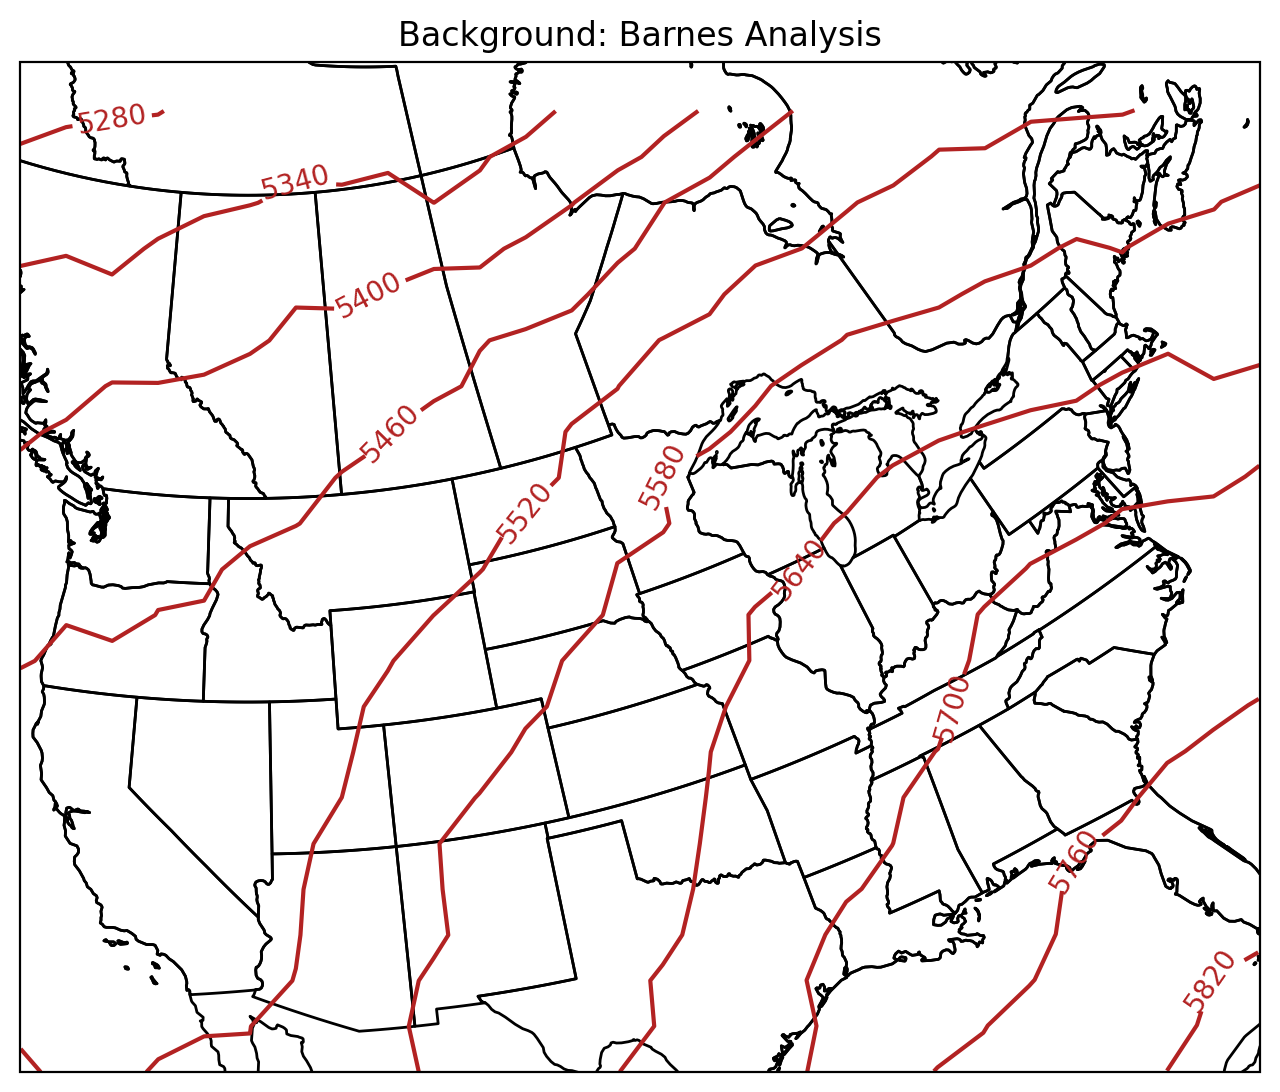

In [5]:
## define K sub d and radius of influence values
kd = .108844524 ## units of m**2
re = .127775892 ## units of m; this is RoI

## call empty zeros array for analysis vals
bkgd = np.zeros((28,22))

## conduct 1st pass barnes analysis using defined weighting function
for i in range(len(xg)):
    for j in range(len(xg[i])):
        xa = xg[i,j]
        ya = yg[i,j]
        dx = xa - obsx
        dy = ya - obsy
        dist = ((dx**2 + dy**2)**0.5)
        theseweights = np.zeros(shape=len(dist))
        for u in range(len(dist)):
            theseweights[u] = wik(dist[u],kd,re) ## creates an array of weights corresponding to obs
        ## weights array for this grid point should be full below this line

        ## iterate through each weight/ob to get analysis value at this point, using the blessed and magical += operator
        ## reset initial values for this pass
        bigk = len(obsxy) - 1 ## number of observations, the -1 is for indexing reasons
        k = 0
        num = 0 ## this will be the numerator in the cressman analysis function, which is a summation
        denom = 0 ## denominator in the cressman analysis function, which is also a summation
        
        while k <= bigk:
            if theseweights[k] == 0:
                k += 1
                continue
            num += (theseweights[k]) * (hght[k])
            denom += theseweights[k]
            k += 1
        #print(num, denom)
        fa = num / denom ## num and denom were summation-ed in the while loop above
        bkgd[i,j] = fa ## populates 1st pass grid with analysis values as they come
        #print('k loop end')

## I am so not sure why these are all fucked up, but it's going to have to be a Tuesday problem

## for reasons that are unbeknownst to me, if I don't have this here, the plot code will not work. 
## i am not in the business of asking questions.
def latlon(x,y):
    #lat = ((np.pi/2) - (2*np.arctan((((((x/m)**2 + (y/m)**2)**.5)/(rho * (1 + np.sin(60 * np.pi/180))))*np.pi/180)))) * (180/np.pi)
    lat = ((np.pi/2) - (2 * np.arctan( (((x/m)**2 + (y/m)**2)**.5) / (rho * (1 + np.sin(60 * (np.pi/180)))) ))) * (180/np.pi)
    lon = np.arctan(y/x)*(180/np.pi) - 115
    return(lat,lon)
    
anlat,anlon = latlon(xg,yg)

## anyways,
## plot background
proj = ccrs.Stereographic(central_longitude=-115,central_latitude=90,true_scale_latitude=60)
fig = plt.figure(figsize=(8,8),dpi=200)
ax1 = fig.add_subplot(111,projection=proj)
ax1.add_feature(cfeature.STATES)
ax1.add_feature(cfeature.COASTLINE)

#plot analysis 
cs1 = ax1.contour(anlon,anlat,bkgd,colors='firebrick',levels=np.arange(0,8000,60),transform=ccrs.PlateCarree())
plt.clabel(cs1,levels=np.arange(0,8000,60))
plt.title('Background: Barnes Analysis')
#plt.savefig('barnes_bkgd.png',dpi=200,bbox_inches='tight')
plt.show()


In [6]:
## forward interpolate using bilinear formula to get analysis values at ob locations
fwd1 = bilinear(obsx,obsy,xg,yg,bkgd,re) ## funny story, I don't think that the previous radius thing actually does anything here
                                         ## however, i am too afraid to remove it, so it stays

## second pass analyses using 2, 4, 10 closest points

## define a function outside the function defining box... really going off the rails here
def nearest(num_points,hght,obsx,obsy,xg,yg,prevfwd,prevanl,rad):
    ## prev is meant to be the forward-interpolated background pass
    ## call empty array to be filled with analysis pass
    thispass = np.zeros(shape=(len(xg),len(xg[0])))
    ## first, find nearest points by assessing all distances for each obs location
    ## iterate through each analysis location for this
    for a in range(len(xg)):
        for s in range(len(xg[a])):
            ## this is the point in loop where we are working with a singular analysis value
            ## create array of dx's, dy's, distances
            this_xg = xg[a,s]
            this_yg = yg[a,s]
            gridpoint_dists = np.zeros(shape=len(hght))
            for d in range(len(hght)):
                dx = (obsx[d] - this_xg) * 100 ## units of cm
                dy = (obsy[d] - this_yg) * 100 ## units of cm
                thisdist = ((dx**2 + dy**2)**0.5) ## units of cm
                ## above 3 lines were adjusted to be consistent w/ instructions because repeatedly doing the math in my head is not fun
                gridpoint_dists[d] = thisdist * 1e-8 ## units of 1000s km, instructions in assignment
                ## when exiting this loop, should have array of distances from one analysis grid point to all obs
            ## god bless numpy argsort
            dist_sorted_idx = np.argsort(gridpoint_dists) ## returns the indices of the smallest to largest value
            nearest_obs_idx = dist_sorted_idx[:num_points] ## returns indices of x closest points
            ## pull obs x, y, obs height, analysis height data, still matched to those indices
            nearest_anheights = prevfwd[nearest_obs_idx]
            nearest_heights = hght[nearest_obs_idx]
            nearest_x = obsx[nearest_obs_idx]
            nearest_y = obsy[nearest_obs_idx]
            nearest_dist = gridpoint_dists[nearest_obs_idx]
            ## set up correlation matrices
            pik = np.zeros(shape=(num_points,num_points))
            pkl = np.zeros(shape=(num_points,num_points))
            ## fill em
            for f in range(num_points):
                dxs = nearest_x[f] - nearest_x
                dys = nearest_y[f] - nearest_y
                #print(dxs,dys)
                dik = ((dxs**2 + dys**2)**0.5)
                ## since dik is a matrix of size num_obs, more looping
                these_dik = np.zeros(shape=(num_points))
                for g in range(num_points):
                    these_dik[g] = schlatter(dik[g])
                pik[f] = these_dik
            ## again for pkl
                these_neardist = np.zeros(shape=(num_points))
                for h in range(num_points):
                    these_neardist[h] = schlatter(nearest_dist[h])
                pkl[f] = these_neardist
            pkl2 = np.matrix(pkl).T
            weights = np.array(np.linalg.inv(pik)*pkl2)
            flat_weights = weights.flatten() 
            #print(np.shape(weights_flat))
            ## run analysis equation, as in previous analyses
            k = 0
            bigk = len(flat_weights) - 1
            insum = 0
            while k <= bigk:
                for l in range(len(nearest_heights)):
                    insum += (flat_weights[k] * (nearest_heights[l] - nearest_anheights[l]))
                k += 1
            thispass[a,s] = prevanl[a,s] + insum
    #print(np.shape(thispass))
    return(thispass)

## lockin em in
near2 = nearest(2,hght,obsx,obsy,xg,yg,fwd1,bkgd,re)
near4 = nearest(4,hght,obsx,obsy,xg,yg,fwd1,bkgd,re)
near10 = nearest(10,hght,obsx,obsy,xg,yg,fwd1,bkgd,re)

## bilinear-ify to get the analysis at ob locations
fwd2 = bilinear(obsx,obsy,xg,yg,near2,re)
fwd4 = bilinear(obsx,obsy,xg,yg,near4,re)
fwd10 = bilinear(obsx,obsy,xg,yg,near10,re)
#print(fwd2,fwd4,fwd10)

## analysis increments
inc2 = near2 - bkgd
inc4 = near4 - bkgd
inc10 = near10 - bkgd

## analysis vs obs
anob2 = fwd2 - hght
anob4 = fwd4 - hght
anob10 = fwd10 - hght

## RMSEs
rmse2 = rmse(hght,fwd2,len(hght))
rmse4 = rmse(hght,fwd4,len(hght))
rmse10 = rmse(hght,fwd10,len(hght))



135 4599153.662363052
135 121239050.99478087
135 4423788088.194998


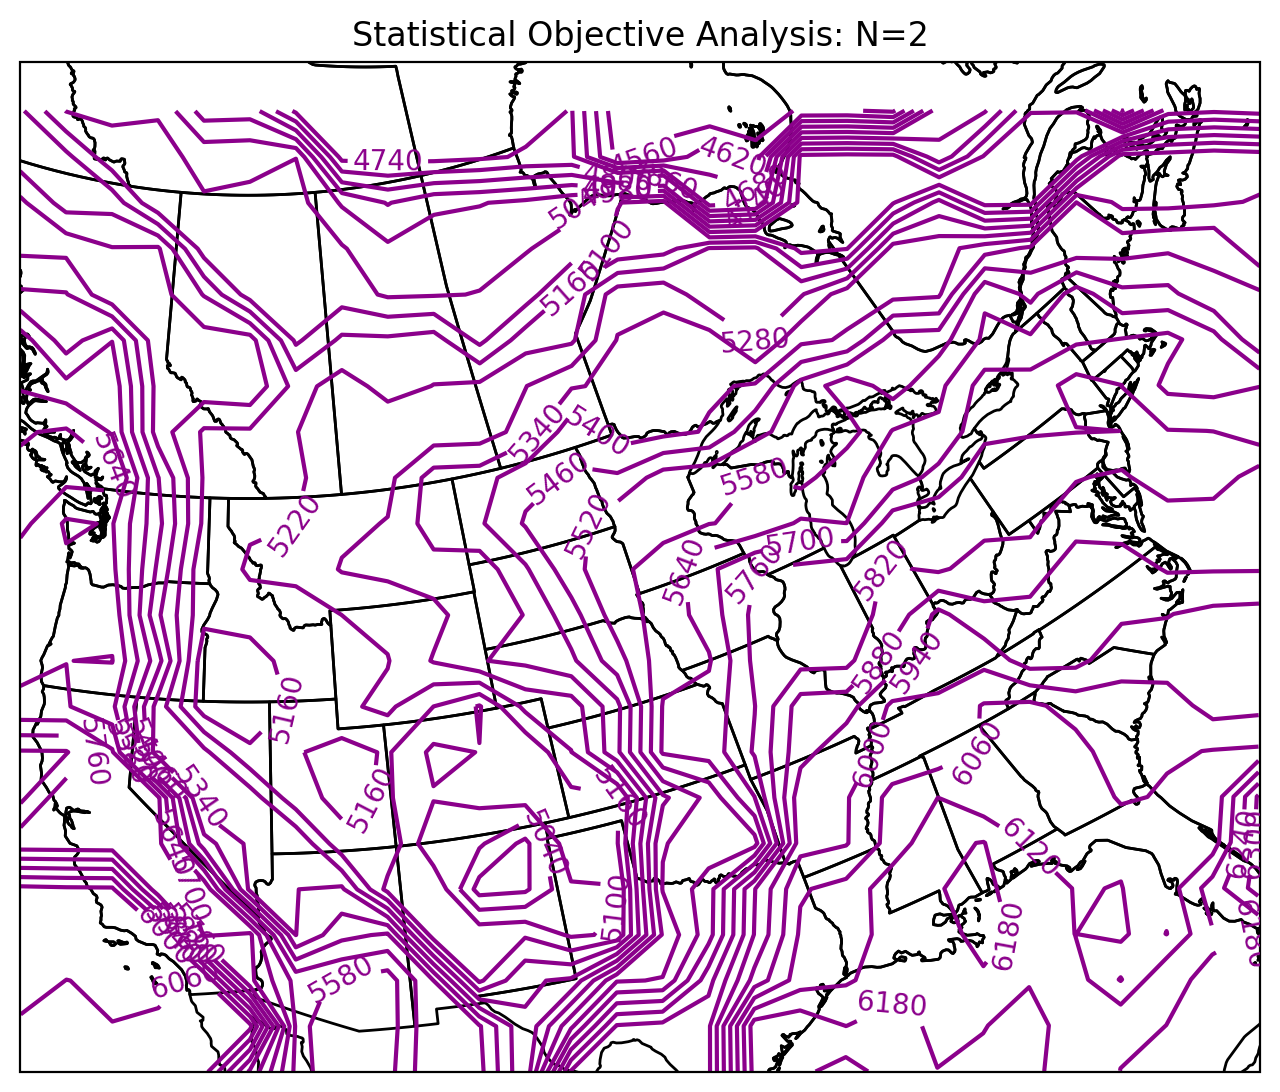

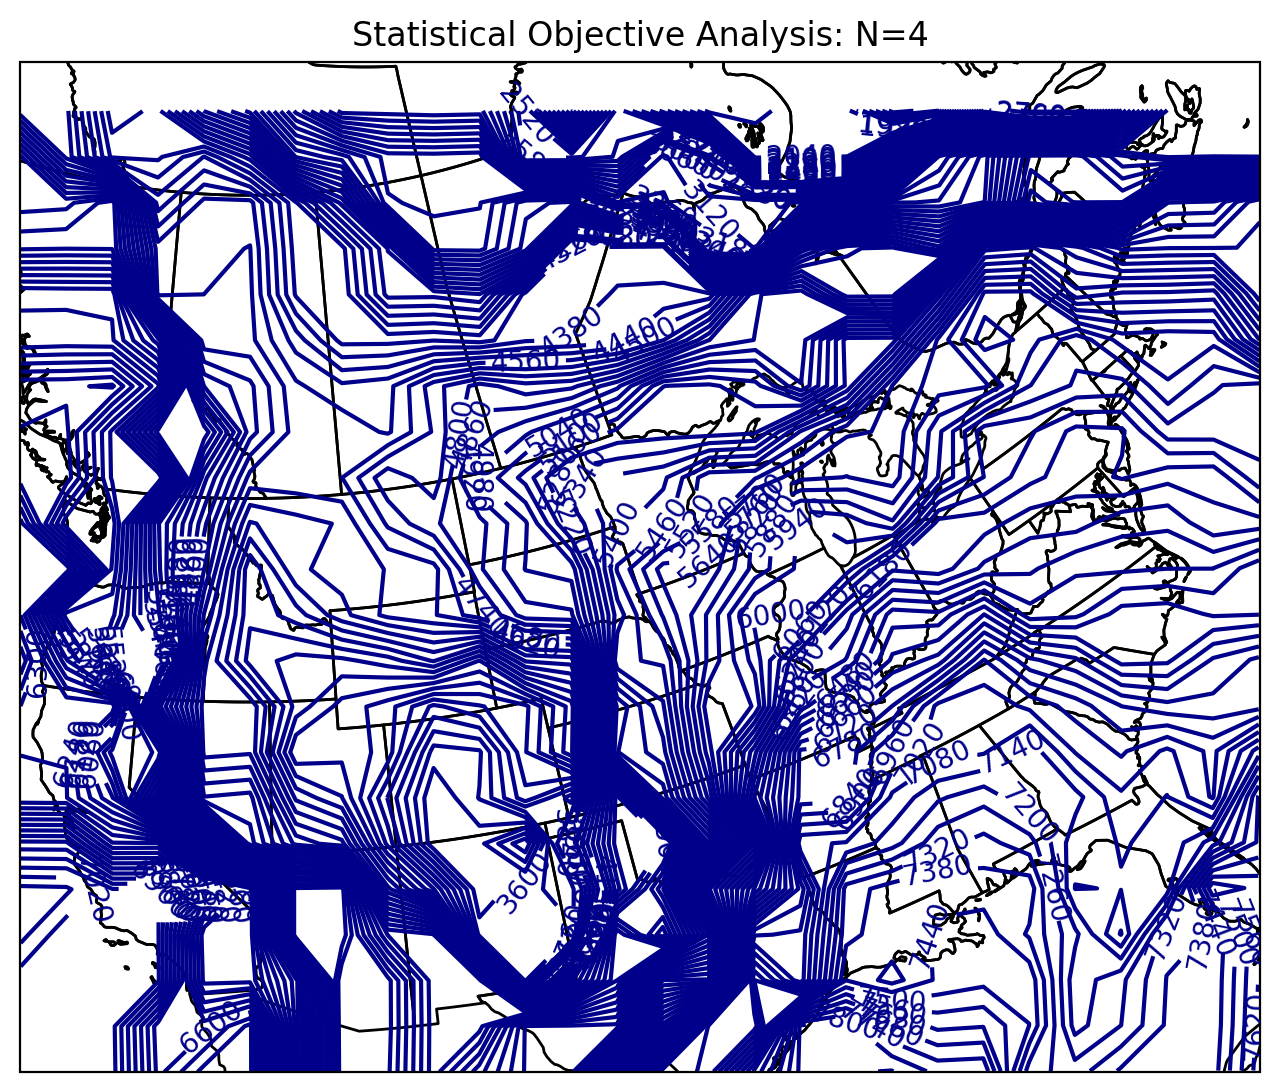

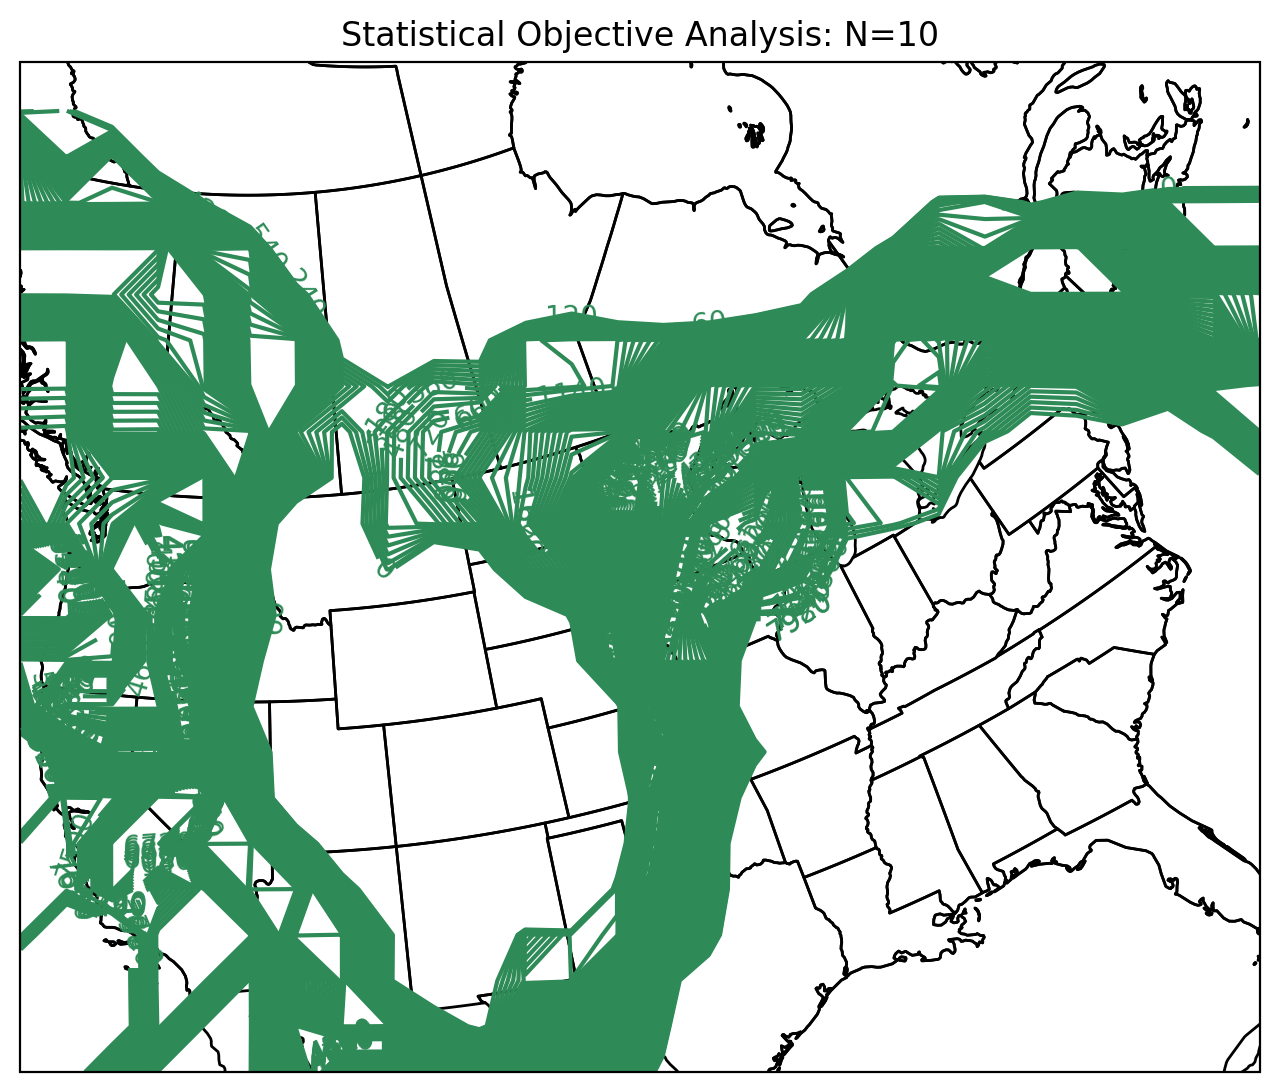

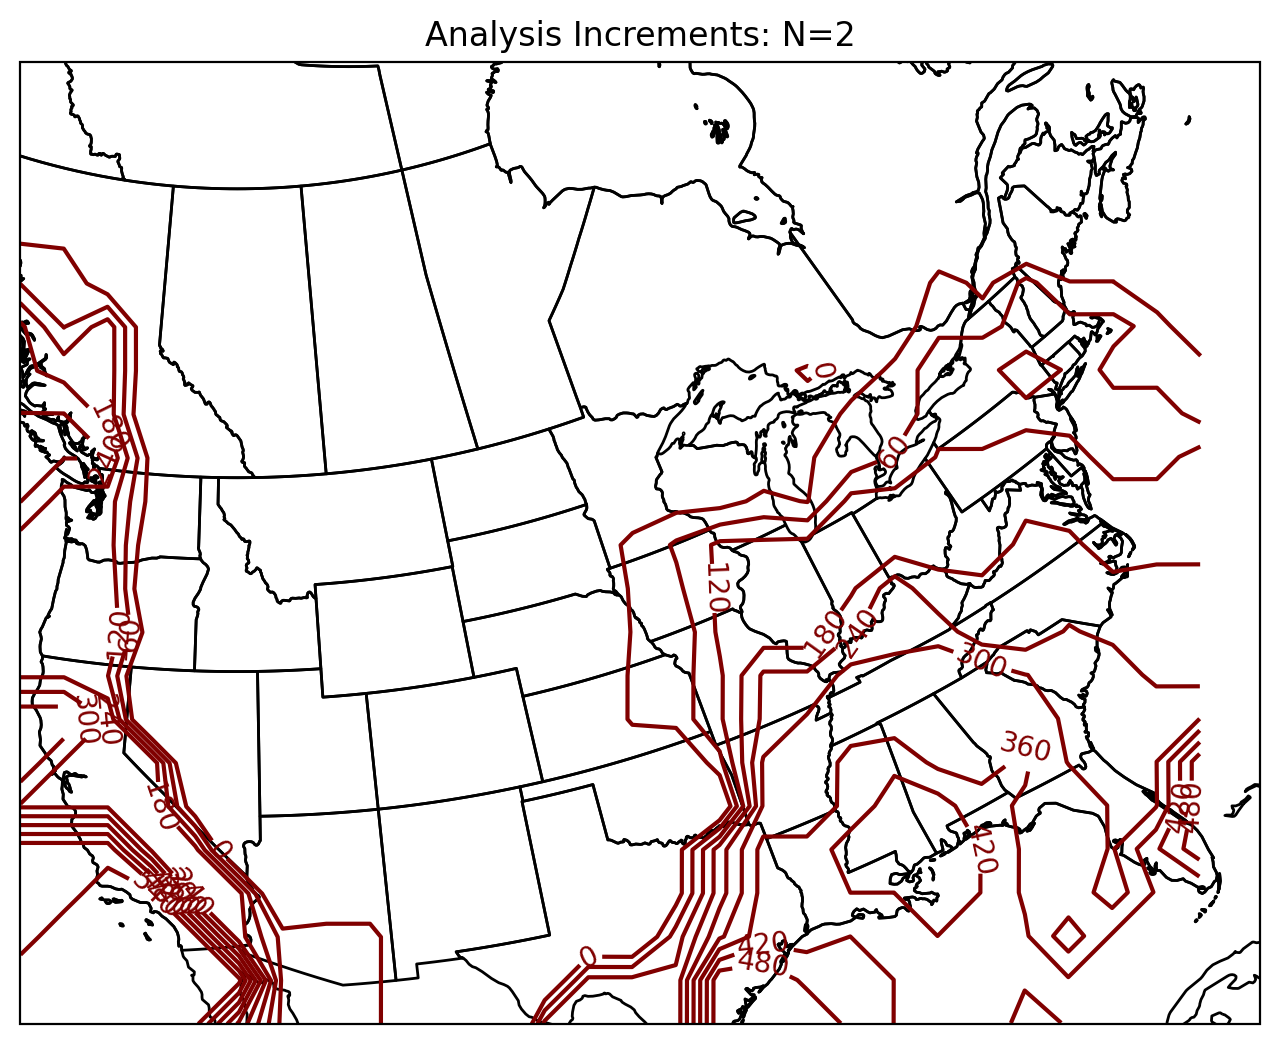

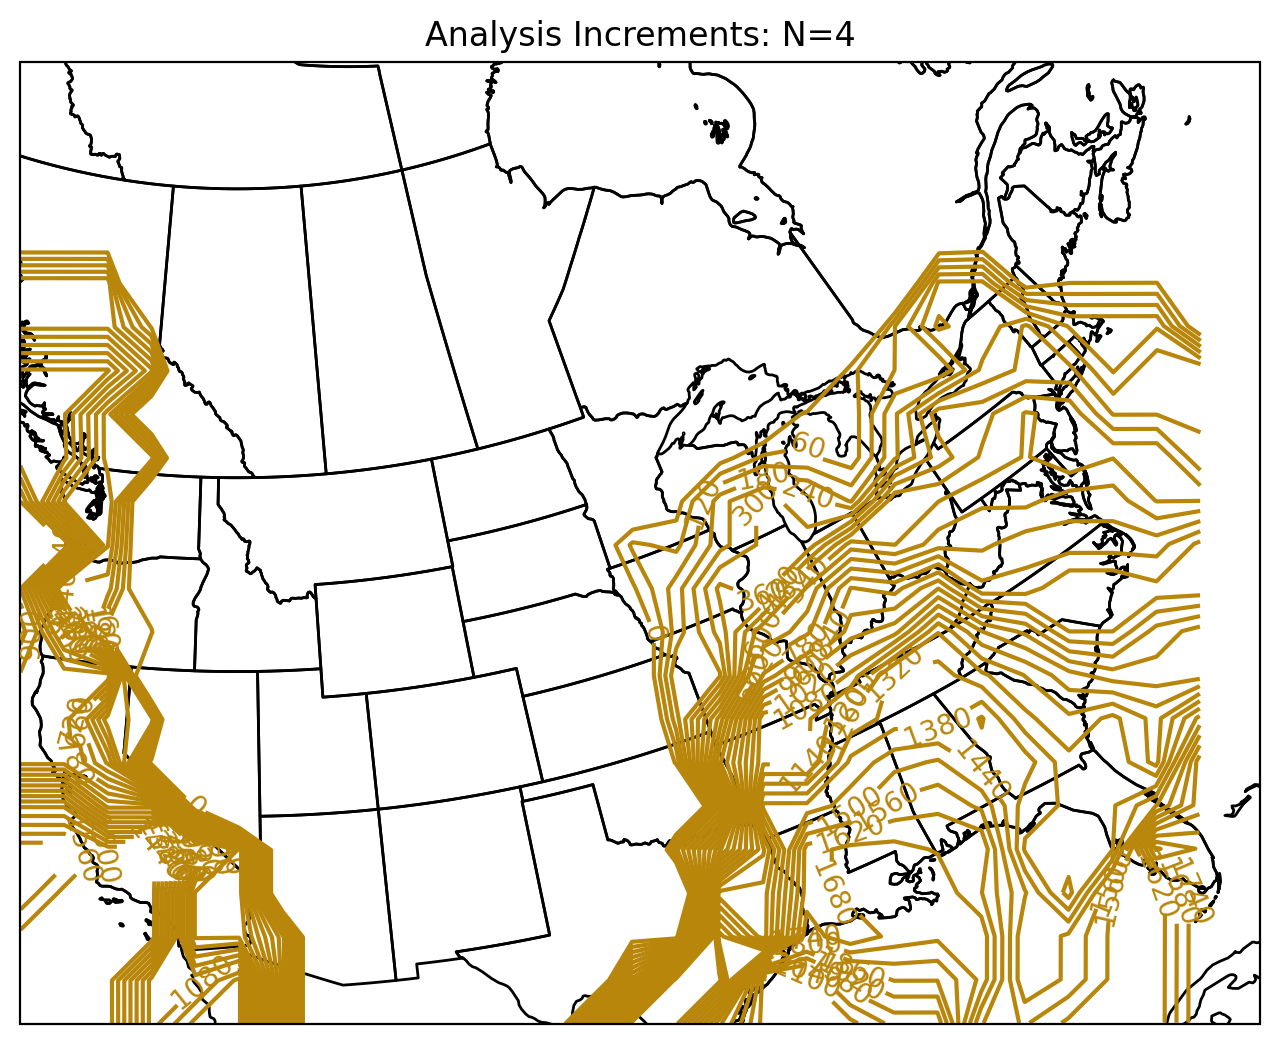

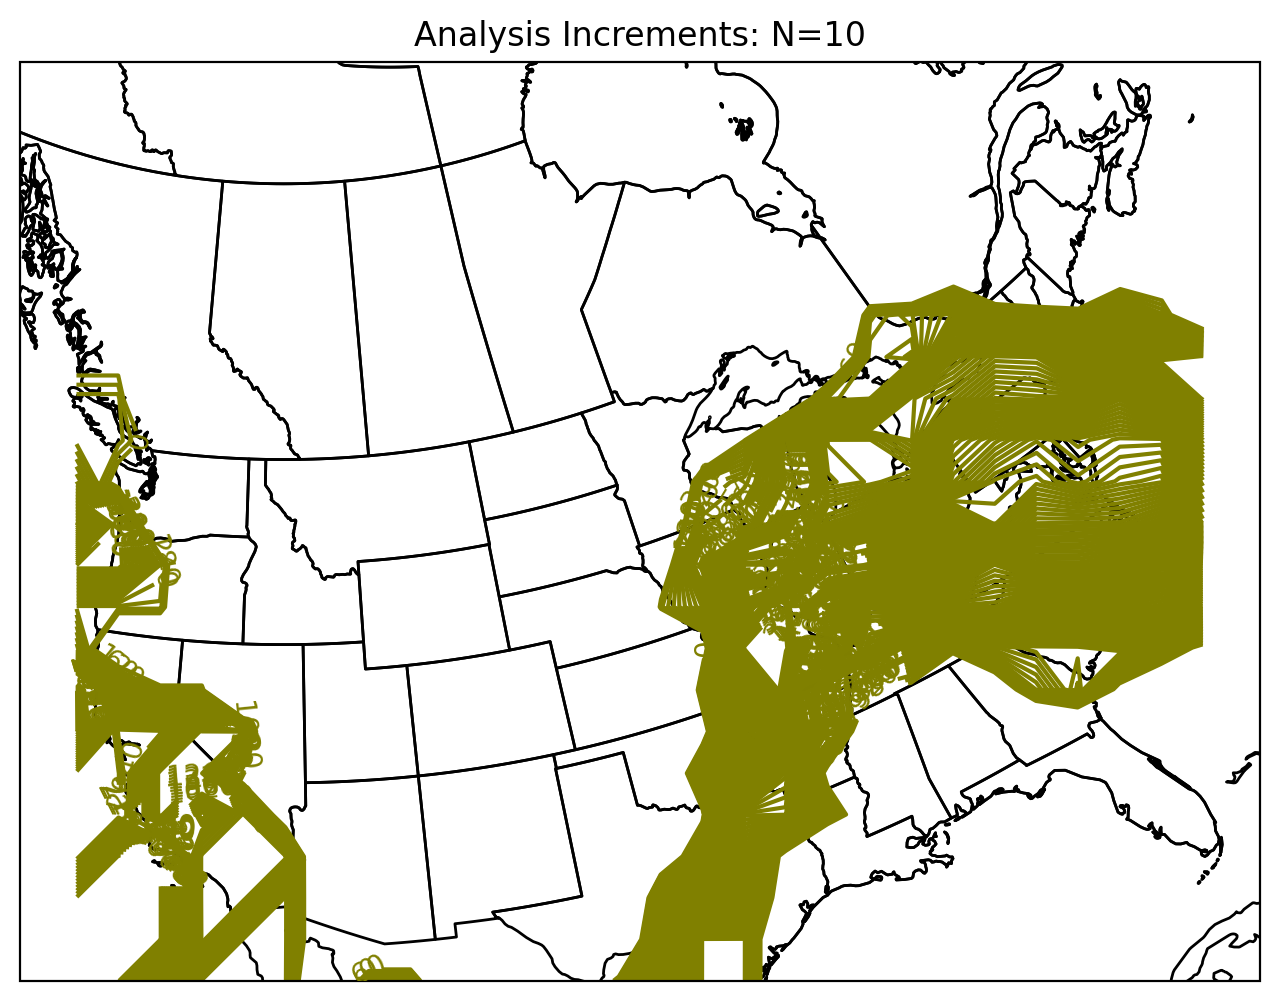

In [12]:
## WOE PLOTS BE UPON YE

## n=2
proj = ccrs.Stereographic(central_longitude=-115,central_latitude=90,true_scale_latitude=60)
fig = plt.figure(figsize=(8,8),dpi=200)
ax1 = fig.add_subplot(111,projection=proj)
ax1.add_feature(cfeature.STATES)
ax1.add_feature(cfeature.COASTLINE)

cs1 = ax1.contour(anlon,anlat,near2,colors='darkmagenta',levels=np.arange(0,8000,60),transform=ccrs.PlateCarree())
plt.clabel(cs1,levels=np.arange(0,8000,60))
plt.title('Statistical Objective Analysis: N=2')
#plt.savefig('near2.png',dpi=200,bbox_inches='tight')
plt.show()

## n=4
proj = ccrs.Stereographic(central_longitude=-115,central_latitude=90,true_scale_latitude=60)
fig = plt.figure(figsize=(8,8),dpi=200)
ax1 = fig.add_subplot(111,projection=proj)
ax1.add_feature(cfeature.STATES)
ax1.add_feature(cfeature.COASTLINE)

cs1 = ax1.contour(anlon,anlat,near4,colors='darkblue',levels=np.arange(0,8000,60),transform=ccrs.PlateCarree())
plt.clabel(cs1,levels=np.arange(0,8000,60))
plt.title('Statistical Objective Analysis: N=4')
#plt.savefig('near4.png',dpi=200,bbox_inches='tight')
plt.show()

## n=10
proj = ccrs.Stereographic(central_longitude=-115,central_latitude=90,true_scale_latitude=60)
fig = plt.figure(figsize=(8,8),dpi=200)
ax1 = fig.add_subplot(111,projection=proj)
ax1.add_feature(cfeature.STATES)
ax1.add_feature(cfeature.COASTLINE)
 
cs1 = ax1.contour(anlon,anlat,near10,colors='seagreen',levels=np.arange(0,8000,60),transform=ccrs.PlateCarree())
plt.clabel(cs1,levels=np.arange(0,8000,60))
plt.title('Statistical Objective Analysis: N=10')
#plt.savefig('near10.png',dpi=200,bbox_inches='tight')
plt.show()

## plot analysis increments
## n=2
proj = ccrs.Stereographic(central_longitude=-115,central_latitude=90,true_scale_latitude=60)
fig = plt.figure(figsize=(8,8),dpi=200)
ax1 = fig.add_subplot(111,projection=proj)
ax1.add_feature(cfeature.STATES)
ax1.add_feature(cfeature.COASTLINE)
 
cs1 = ax1.contour(anlon,anlat,inc2,colors='maroon',levels=np.arange(0,8000,60),transform=ccrs.PlateCarree())
plt.clabel(cs1,levels=np.arange(0,8000,60))
plt.title('Analysis Increments: N=2')
#plt.savefig('aninc2.png',dpi=200,bbox_inches='tight')
plt.show()

## n=4
proj = ccrs.Stereographic(central_longitude=-115,central_latitude=90,true_scale_latitude=60)
fig = plt.figure(figsize=(8,8),dpi=200)
ax1 = fig.add_subplot(111,projection=proj)
ax1.add_feature(cfeature.STATES)
ax1.add_feature(cfeature.COASTLINE)
 
cs1 = ax1.contour(anlon,anlat,inc4,colors='darkgoldenrod',levels=np.arange(0,8000,60),transform=ccrs.PlateCarree())
plt.clabel(cs1,levels=np.arange(0,8000,60))
plt.title('Analysis Increments: N=4')
#plt.savefig('aninc4.png',dpi=200,bbox_inches='tight')
plt.show()

## n=10
proj = ccrs.Stereographic(central_longitude=-115,central_latitude=90,true_scale_latitude=60)
fig = plt.figure(figsize=(8,8),dpi=200)
ax1 = fig.add_subplot(111,projection=proj)
ax1.add_feature(cfeature.STATES)
ax1.add_feature(cfeature.COASTLINE)
 
cs1 = ax1.contour(anlon,anlat,inc10,colors='olive',levels=np.arange(0,8000,60),transform=ccrs.PlateCarree())
plt.clabel(cs1,levels=np.arange(0,8000,60))
plt.title('Analysis Increments: N=10')
#plt.savefig('aninc10.png',dpi=200,bbox_inches='tight')
plt.show()


In [ ]:
## write outputs to text files
## statistical objective analyses
nearest2 = open('nearest2.txt','w')
nearest2.write(f'The following are analysis values for a statistical objective analysis N=2: {near2}')
nearest2.close()

nearest4 = open('nearest4.txt','w')
nearest4.write(f'The following are analysis values for a statistical objective analysis N=4: {near4}')
nearest4.close()

nearest10 = open('nearest10.txt','w')
nearest10.write(f'The following are analysis values for a statistical objective analysis N=10: {near10}')
nearest10.close()

## forward interpolated values
fwd2 = open('fwd2.txt','w')
fwd2.write(f'The following are forward-interpolated values based upon the N=2 analysis: {fwd2}')
fwd2.close()

fwd4 = open('fwd4.txt','w')
fwd4.write(f'The following are forward-interpolated values based upon the N=4 analysis: {fwd4}')
fwd4.close()

fwd10 = open('fwd10.txt','w')
fwd10.write(f'The following are forward-interpolated values based upon the N=10 analysis: {fwd10}')
fwd10.close()

## analysis differences (analysis vs obs)
andiff2 = open('andiff2.txt','w')
andiff2.write(f'The following are analysis difference values based upon the N=2 analysis: {anob2}')
andiff2.close()

andiff4 = open('andiff4.txt','w')
andiff4.write(f'The following are analysis difference values based upon the N=4 analysis: {anob4}')
andiff4.close()

andiff10 = open('andiff10.txt','w')
andiff10.write(f'The following are analysis difference values based upon the N=10 analysis: {anob10}')
andiff10.close()

## analysis increments (analysis vs background)
aninc2 = open('aninc2.txt','w')
aninc2.write(f'The follwowing are analysis increment values based upon the N=2 analysis: {inc2}')
aninc2.close()

aninc4 = open('aninc4.txt','w')
aninc4.write(f'The follwowing are analysis increment values based upon the N=4 analysis: {inc4}')
aninc4.close()

aninc10 = open('aninc10.txt','w')
aninc10.write(f'The follwowing are analysis increment values based upon the N=10 analysis: {inc10}')
aninc10.close()

## RMSEs
rmsevals = open('rmsevalues.txt','w')
rmsevals.write(f'The following are the RMSE values for the 2-point, 4-point, and 10-point analyses, respectively: {rmse2}, {rmse4}, {rmse10}')
rmsevals.close()

In [8]:
### In a separte text file (or below), answer the following questions ###
'''
1 - Describe the general features that you see in your contoured analyses.
    

2 - Describe the differences that you see in your contoured analyses.  
    Does one analysis seem to be smoother than the other?  If so, what would cause this?
    

3 - What happens as you increase the number of points considered for the analysis?  Is this 
    desirable?  Why or why not?

    When more points are considered, the analysis becomes smoother. This is desirable when
    focusing on large-scale features such as troughs and ridges, but creating too smooth of
    an analysis results in the obscuration of small-scale features such as shortwave troughs/ridges.
    
'''

'\n1 - Describe the general features that you see in your contoured analyses.\n    \n\n2 - Describe the differences that you see in your contoured analyses.  \n    Does one analysis seem to be smoother than the other?  If so, what would cause this?\n    \n\n3 - What happens as you increase the number of points considered for the analysis?  Is this \n    desirable?  Why or why not?\n    \n'